In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
#Since this CSV file dosen`t have the 'Last' or the 'Settle' collumn I`ll considerate the 'High' as the 'Settle' price  
cad_jpy_df['Settle'] =  (cad_jpy_df[['High']]) 
cad_jpy_df.head()

,Price,Open,High,Low,Settle
Date,,,,,
1982-01-05,184.65,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low,Settle
Date,,,,,
1990-01-02,126.37,126.31,126.37,126.31,126.37
1990-01-03,125.30,125.24,125.30,125.24,125.30
1990-01-04,123.46,123.41,123.46,123.41,123.46
1990-01-05,124.54,124.48,124.54,124.48,124.54
1990-01-08,124.27,124.21,124.27,124.21,124.27


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Settle Prices'}, xlabel='Date'>

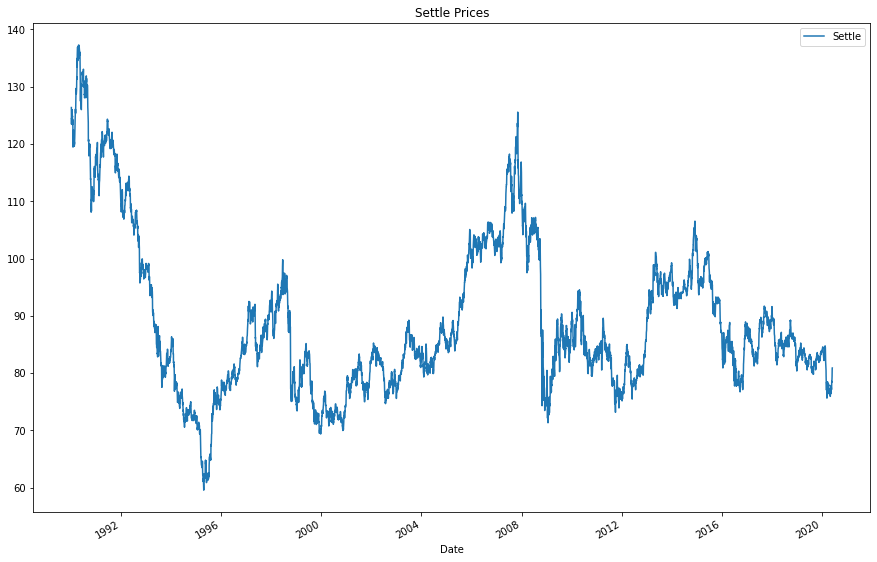

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Settle.plot(figsize=[15,10],title='Settle Prices',legend=True)

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:**  Hard to analyse using the High price as Settle

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Settle'])

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_df = cad_jpy_df[['Settle']].copy()
cad_jpy_df['Trend'] = ts_trend
cad_jpy_df['Noise'] = ts_noise
cad_jpy_df.tail()

,Settle,Trend,Noise
Date,,,
2020-05-29,78.41,78.999348,-0.589348
2020-06-01,79.36,79.240125,0.119875
2020-06-02,80.56,79.484645,1.075355
2020-06-03,80.82,79.730986,1.089014
2020-06-04,80.89,79.977897,0.912103


<AxesSubplot:title={'center':'Settle vs Trend'}, xlabel='Date'>

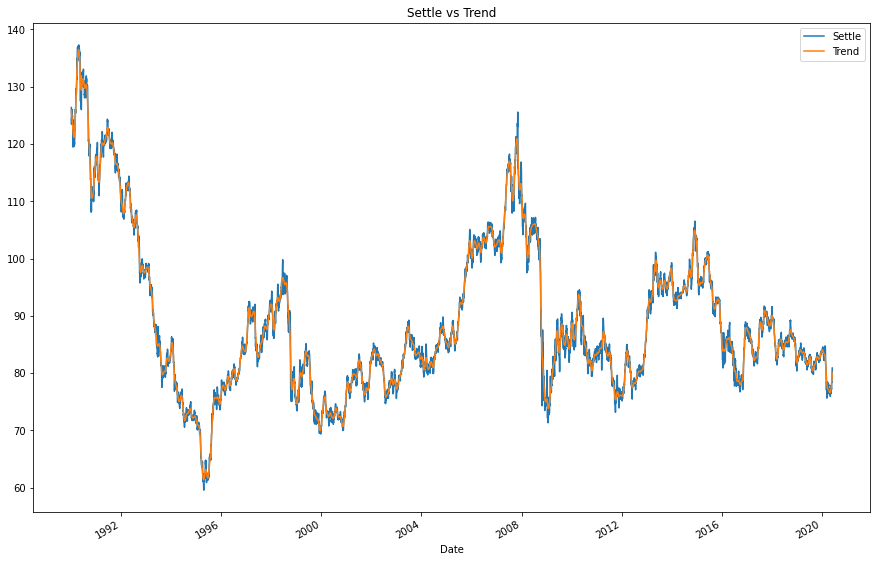

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
cad_jpy_df.plot(y=['Settle', 'Trend'],figsize=[15,10],title='Settle vs Trend',legend=True)

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Hard to analyse using the High price as Settle but the Trend has smaller absolute values and it can show some opportunity to buy and sell

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

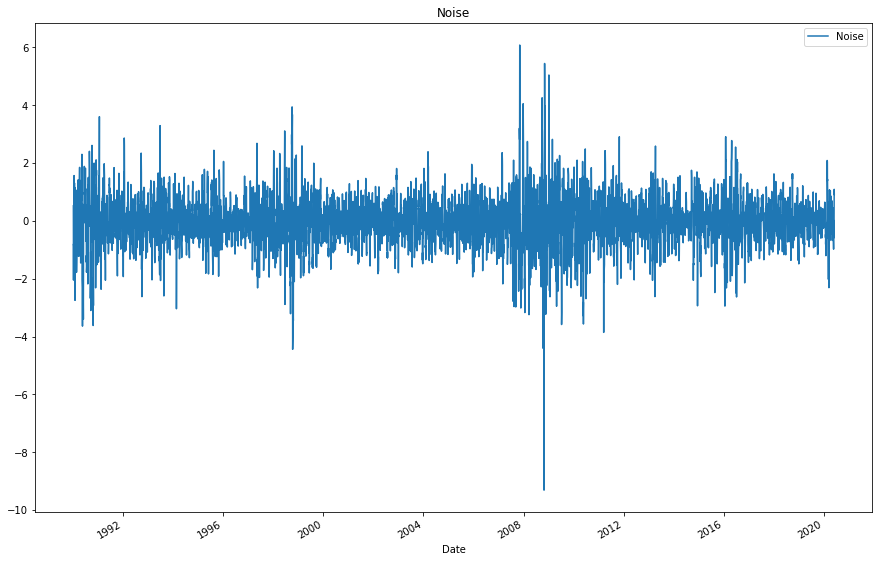

In [8]:
# Plot the Settle Noise
cad_jpy_df.plot(y='Noise',figsize=[15,10],title='Noise',legend=True)

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2020-05-29,-0.140092
2020-06-01,1.211580
2020-06-02,1.512097
2020-06-03,0.322741
2020-06-04,0.086612


In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -8176.090
Method:                       css-mle   S.D. of innovations              0.679
Date:                Thu, 22 Jul 2021   AIC                          16362.180
Time:                        15:12:13   BIC                          16397.070
Sample:                             0   HQIC                         16374.128
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.009     -0.380      0.704      -0.020       0.014
ar.L1.y        0.3310      0.509      0.651      0.515      -0.666       1.328
ar.L2.y       -0.0463      0.070     -0.666      0.505      -0.183       0.090
ma.L1.y       -0.1895      0.509     -0.372      0.710      -1.187       0.808
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5728           -2.9708j            4.6465           -0.1104
AR.2            3.5728           +2.9708j            4.6465            0.1104
MA.1            5.2781           +0.0000j            5.2781            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

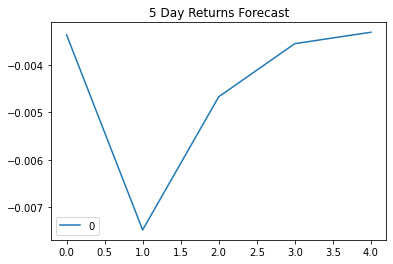

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:**  Good fit given the p-value dont exceeds 0.05

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(cad_jpy_df['Settle'], order = (5, 1, 1))

# Fit the model
results = model.fit()

C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\lucas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7216.707
Method:                       css-mle   S.D. of innovations              0.601
Date:                Thu, 22 Jul 2021   AIC                          14449.415
Time:                        15:12:17   BIC                          14505.240
Sample:                             1   HQIC                         14468.531
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0058      0.008     -0.742      0.458      -0.021       0.009
ar.L1.D.Settle     0.3859      0.614      0.629      0.530      -0.817       1.589
ar.L2.D.Settle    -0.0440      0.089     -0.493      0.622      -0.219       0.131
ar.L3.D.Settle    -0.0071      0.013     -0.535      0.593      -0.033       0.019
ar.L4.D.Settle     0.0160      0.013      1.206      0.228      -0.010       0.042
ar.L5.D.Settle    -0.0107      0.013     -0.822      0.411      -0.036       0.015
ma.L1.D.Settle    -0.2417      0.614     -0.394      0.694      -1.445       0.961
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.6540           -0.0000j            2.6540           -0.5000
AR.2           -0.0286           -2.5421j            2.5422           -0.2518
AR.3           -0.0286           +2.5421j            2.5422            0.2518
AR.4            2.1021           -1.0150j            2.3343           -0.0716
AR.5            2.1021           +1.0150j            2.3343            0.0716
MA.1            4.1366           +0.0000j            4.1366            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

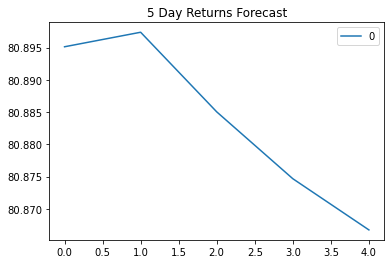

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The High value is expected to decrease

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
from arch import arch_model

In [17]:
# Estimate a GARCH model:
model = arch_model(returns['Settle'], mean="Zero", vol="GARCH", p=2,q=1)

# Fit the model
results = model.fit(disp="off")

In [18]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7523.81
Distribution:                  Normal   AIC:                           15055.6
Method:            Maximum Likelihood   BIC:                           15083.5
                                        No. Observations:                 7928
Date:                Thu, Jul 22 2021   Df Residuals:                     7928
Time:                        15:12:22   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.1147e-03  1.901e-03      2.690  7.140e-03  [1.388e-03,8.841e-03]
alpha[1]       0.0486  1.507e-02      3.227  1.250e-03  [1.909e-02,7.816e-02]
alpha[2]       0.0000  1.928e-02      0.000      1.000 [-3.778e-02,3.778e-02]
beta[1]        0.9405  1.370e-02     68.667      0.000      [  0.914,  0.967]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,10.868225,10.868361,10.868495,10.868628,10.868759


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,10.868225
h.2,10.868361
h.3,10.868495
h.4,10.868628
h.5,10.868759


In [23]:
# Plot the final forecast
final_forecast = intermediate.dropna().T
final_forecast.head()

Date,2020-06-04
h.1,10.868225
h.2,10.868361
h.3,10.868495
h.4,10.868628
h.5,10.868759


**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** YOUR ANSWER HERE

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * Hard to do a good analysis with my dada set, but I would say to wait do to the new Covid cases in Japan the Yen can decrease more in value.

2. Is the risk of the yen expected to increase or decrease?
    * If covid cases keep increasing and the summer olympic game not become a sucess also due to the covid, is more likely we see an increase in risk

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * If I have the last price or the settlement column for sure